In [15]:
import pandas as pd
import numpy as np

from env import user, password, host

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")
import acquire
import prepare

# Exercises II

Let's set up an example scenario as perspective for our regression exercises using the Zillow dataset.

As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the obervations from 2017.

In these exercises, you will complete the first step toward the above goal: acquire and prepare the necessary Zillow data from the zillow database in the Codeup database server.

1)`Acquire bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, and fips from the zillow database for all 'Single Family Residential' properties`.

2)`Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaningful; remember to document your process and decisions using markdown and code commenting where helpful`.


3)`Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe with no missing values in your wrangle.py file. Name your final function wrangle_zillow`.

# Acquire

In [2]:
#csv clean 
def clean_zillow():
    '''Read zillow csv file into a pandas DataFrame,
    renamed all of the columuns, replace NaN values with 0 ,
    keep all the 0 values, convert all columns to int64,
    return cleaned zillow DataFrame'''
    df=pd.read_csv('zillow.csv')
    df = df.rename(columns={'bedroomcnt': 'Bedrooms', 'bathroomcnt': 'Bathrooms','calculatedfinishedsquarefeet':'Squarefeet',
                       "taxvaluedollarcnt":'TaxesTotal','yearbuilt':'Year','taxamount':'Taxes','fips':'Fips'})
    return df
#sql clean   
def sqlclean_zillow():
    query = """
            
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017

    LEFT JOIN propertylandusetype USING(propertylandusetypeid)

    WHERE propertylandusedesc IN ("Single Family Residential",                       
                                  "Inferred Single Family Residential") """

    url = f"mysql+pymysql://{user}:{password}@{host}/zillow"
    df = pd.read_sql(query,url)
    df = df.rename(columns={'bedroomcnt': 'Bedrooms', 'bathroomcnt': 'Bathrooms','calculatedfinishedsquarefeet':'Squarefeet',
                       "taxvaluedollarcnt":'TaxesTotal','yearbuilt':'Year','taxamount':'Taxes','fips':'Fips'})
    return df


    

In [3]:
#to slow
query = """
            
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017

    LEFT JOIN propertylandusetype USING(propertylandusetypeid)

    WHERE propertylandusedesc IN ("Single Family Residential",                       
                                  "Inferred Single Family Residential") """

url = f"mysql+pymysql://{user}:{password}@{host}/zillow"
df = pd.read_sql(query,url)

In [3]:
df=pd.read_csv('zillow.csv')
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037
1,0.0,0.0,NaN,10.0,NaN,NaN,6037
2,0.0,0.0,NaN,10.0,NaN,NaN,6037
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152864 entries, 0 to 2152863
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          int64  
dtypes: float64(6), int64(1)
memory usage: 115.0 MB


In [5]:
df.isnull().sum()

bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8485
taxvaluedollarcnt                493
yearbuilt                       9338
taxamount                       4442
fips                               0
dtype: int64

# Cleaning:

In [6]:
df = df.rename(columns={'bedroomcnt': 'Bedrooms', 'bathroomcnt': 'Bathrooms','calculatedfinishedsquarefeet':'Squarefeet',
                       "taxvaluedollarcnt":'TaxesTotal','yearbuilt':'Year','taxamount':'Taxes','fips':'Fips'})

In [7]:
df.head()

,Bedrooms,Bathrooms,Squarefeet,TaxesTotal,Year,Taxes,Fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037
1,0.0,0.0,NaN,10.0,NaN,NaN,6037
2,0.0,0.0,NaN,10.0,NaN,NaN,6037
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037


In [8]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [9]:
df = remove_outliers(df, 1.5, ['Bedrooms', 'Bathrooms', 'Squarefeet','TaxesTotal','Taxes'])
df.Fips = df.Fips.astype(object)
df.Year = df.Year.astype(object)

In [18]:
x_train_and_validate, x_test = train_test_split(df, random_state=123)
x_train, x_validate = train_test_split(x_train_and_validate)
train.shape,validate.shape,test.shape

((1038959, 7), (445269, 7), (371057, 7))

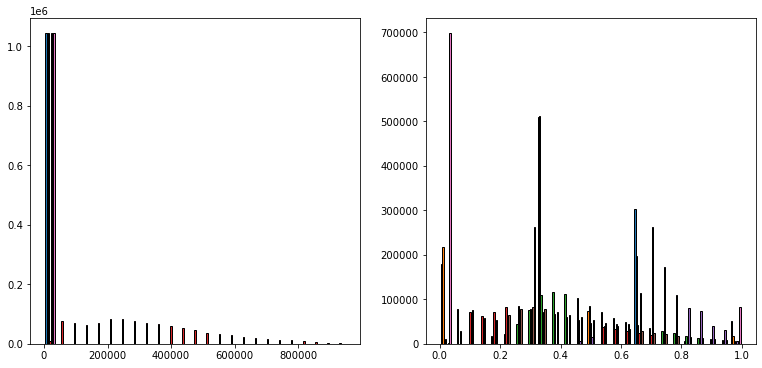

In [21]:
scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(x_train, bins=25, ec='black')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.show()

In [22]:
df.describe()

,Bedrooms,Bathrooms,Squarefeet,TaxesTotal,Taxes
count,1.855285e+06,1.855285e+06,1.855285e+06,1.855285e+06,1.855285e+06
mean,3.214593e+00,2.053629e+00,1.653860e+03,3.279478e+05,4.069332e+03
std,7.814636e-01,7.077294e-01,5.646424e+02,1.989687e+05,2.242381e+03
min,2.000000e+00,1.000000e+00,1.000000e+00,2.200000e+01,1.648000e+01
25%,3.000000e+00,2.000000e+00,1.231000e+03,1.738060e+05,2.366340e+03
50%,3.000000e+00,2.000000e+00,1.548000e+03,2.966210e+05,3.747010e+03
75%,4.000000e+00,2.500000e+00,1.988000e+03,4.525000e+05,5.487570e+03
max,5.000000e+00,4.000000e+00,3.410000e+03,9.509400e+05,1.037784e+04


In [12]:
df.head()

,Bedrooms,Bathrooms,Squarefeet,TaxesTotal,Year,Taxes,Fips
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037
18,3.0,1.0,1244.0,169471.0,1950.0,2532.88,6037
19,3.0,2.0,1300.0,233266.0,1950.0,3110.99,6037
20,3.0,2.0,1222.0,290492.0,1951.0,3870.25,6037


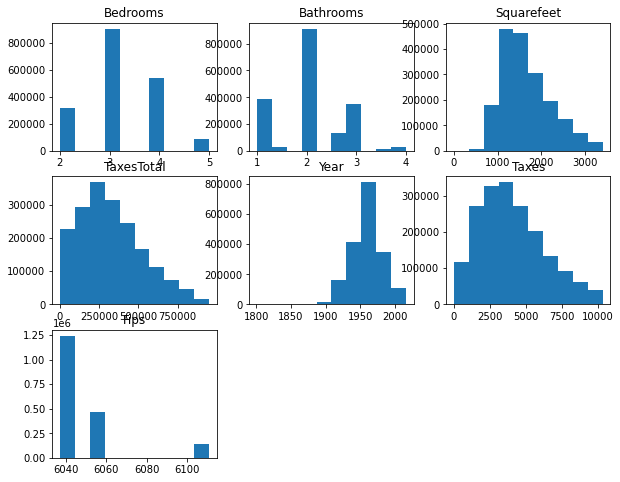

In [13]:
plt.figure(figsize=(10, 8))

# List of columns
cols = ['Bedrooms', 'Bathrooms', 'Squarefeet','TaxesTotal','Year','Taxes','Fips']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(3,3, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist()

    # Hide gridlines.
    plt.grid(False)

# Functions 

In [27]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [28]:
def clean_zillow():
    '''Read zillow csv file into a pandas DataFrame,
    renamed all of the columuns, replace NaN values with 0 ,
    keep all the 0 values, convert all columns to int64,
    return cleaned zillow DataFrame'''
    df=pd.read_csv('zillow.csv')
    df = df.rename(columns={'bedroomcnt': 'Bedrooms', 'bathroomcnt': 'Bathrooms','calculatedfinishedsquarefeet':'Squarefeet',
                       "taxvaluedollarcnt":'TaxesTotal','yearbuilt':'Year','taxamount':'Taxes','fips':'Fips'})
    return df

In [5]:
def prepare_zillow(df):
    ''' Prepare zillow data for exploration'''

    # removing outliers
    df = remove_outliers(df, 1.5, ['Bedrooms', 'Bathrooms', 'Squarefeet','TaxesTotal','Taxes'])
    # converting column datatypes
    df.Fips = df.Fips.astype(object)
    df.Year = df.Year.astype(object)
    
    # train/validate/test split
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    
    # impute year built using mode
    imputer = SimpleImputer(strategy='median')

    imputer.fit(train[['Year']])

    train[['Year']] = imputer.transform(train[['Year']])
    validate[['Year']] = imputer.transform(validate[['Year']])
    test[['Year']] = imputer.transform(test[['Year']]) 
    return train, validate, test

In [30]:
df2=df.copy()

In [31]:
prepare.prepare_zillow(df2)

(         Bedrooms  Bathrooms  Squarefeet  TaxesTotal    Year    Taxes  Fips
 1651747       4.0        2.0      2065.0    113825.0  1947.0  1715.40  6037
 1027146       3.0        2.0      2154.0    470112.0  1967.0  5861.20  6037
 2085017       3.0        2.0      1287.0    280772.0  1963.0  3566.49  6037
 432622        4.0        2.0      2298.0    651600.0  1960.0  8028.52  6037
 783372        4.0        3.0      2378.0    685327.0  1969.0  7735.62  6059
 ...           ...        ...         ...         ...     ...      ...   ...
 806444        3.0        2.5      2081.0    460482.0  1977.0  4769.22  6059
 1190440       3.0        2.0      1227.0    401538.0  1956.0  4668.09  6037
 1406880       3.0        2.0      1332.0    247749.0  1977.0  3272.30  6037
 1117267       3.0        2.0      1035.0    247351.0  1957.0  3151.08  6059
 2110613       4.0        3.0      2788.0    708847.0  1962.0  8722.78  6037
 
 [784487 rows x 7 columns],
          Bedrooms  Bathrooms  Squarefeet  Tax

# Exploration

# Exercises

Our Zillow scenario continues:

As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the observations from 2017.

In these exercises, you will run through the stages of exploration as you continue to work toward the above goal.

As with encoded vs. unencoded data, we recommend exploring un-scaled data in your EDA process.

Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

Save the functions you have written to create visualizations in your explore.py file. Rewrite your notebook code so that you are using the functions imported from this file.

Use the functions you created above to explore your Zillow train dataset in your explore.ipynb notebook.

Come up with some initial hypotheses based on your goal of predicting property value.

Visualize all combinations of variables in some way.

Run the appropriate statistical tests where needed.

What independent variables are correlated with the dependent variable, home value?

Which independent variables are correlated with other independent variables (bedrooms, bathrooms, year built, square feet)?

Make sure to document your takeaways from visualizations and statistical tests as well as the decisions you make throughout your process.

Explore your dataset with any other visualizations you think will be helpful.

# Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

In [23]:
train.shape

(1038959, 7)

# Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

# Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

In [21]:
def cat_and_con(df,['columns'])

,Bedrooms,Bathrooms,Squarefeet,TaxesTotal
Bedrooms,1.000000,0.580249,0.593592,0.200161
Bathrooms,0.580249,1.000000,0.762476,0.354842
Squarefeet,0.593592,0.762476,1.000000,0.423012
TaxesTotal,0.200161,0.354842,0.423012,1.000000


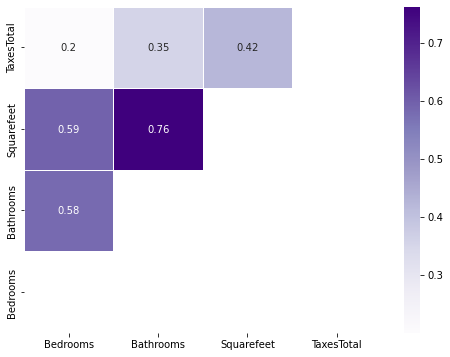

In [22]:
exam_corr = train.drop(columns=['Taxes']).corr()
plt.figure(figsize=(8,6))
sns.heatmap(exam_corr, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(exam_corr))
plt.ylim(0, 4)

plt.show()

<AxesSubplot:xlabel='Taxes', ylabel='Count'>

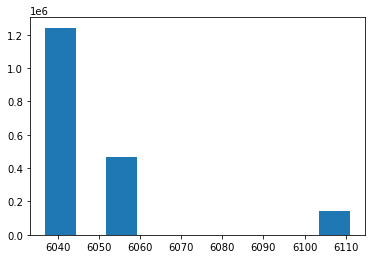

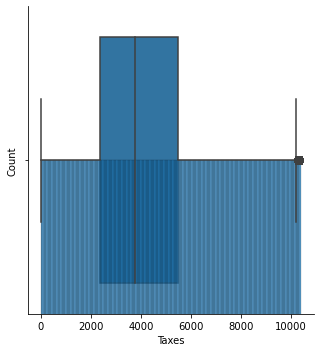

In [51]:
df[col].hist(grid=False, bins=10)
sns.displot(x='Taxes', data=df)
sns.boxplot(x='Taxes',data=df)

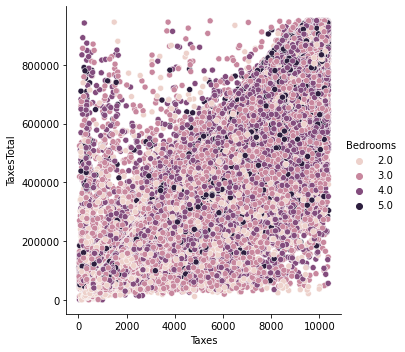

In [34]:
sns.relplot(x="Taxes", y="TaxesTotal", data=train, hue='Bedrooms')
plt.show()

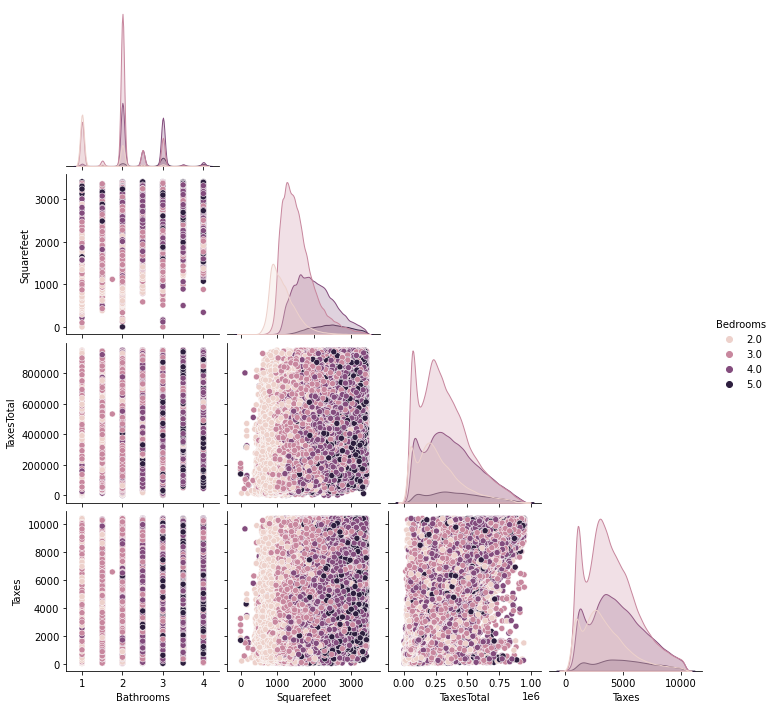

In [38]:
sns.pairplot(x_train[['Bedrooms', 'Bathrooms', 'Squarefeet','TaxesTotal','Taxes']], corner=True , hue='Bedrooms')
plt.show()

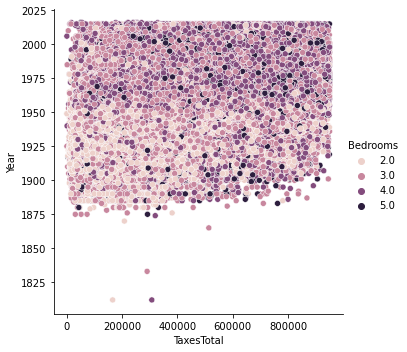

In [50]:
sns.relplot(x="TaxesTotal" , y='Year', data=train, hue='Bedrooms', height=5)
plt.show()

AttributeError: 'Rectangle' object has no property 'normed'

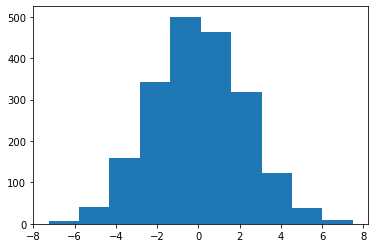

In [64]:
data = np.random.multivariate_normal([0, 0], [[5, 2], [2, 2]], size=2000)
data = pd.DataFrame(data, columns=["x","y"])

for col in 'x':
    plt.hist(data[col], normed=True, alpha=0.5)